In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import datetime
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
warnings.filterwarnings('ignore')

# 1) Sarima Model Optimization

## 1.1) Cleaning the Data

### Saving clean DF

In [2]:
#model_df.to_csv('../data/prices_scores_clean.csv')

In [3]:
#prices_greed_df = pd.merge(prices_df,greed_df,on='date')
#prices_greed_df = prices_greed_df.set_index('date')
#prices_greed_df.to_csv('../data/prices_greed_score_clean.csv')

### Retrieving DF from folder

In [2]:
augmento_df = pd.read_csv('../data/prices_scores_clean.csv')
augmento_df.columns = ['date', 'price', 'BTC_score','twitter_score','reddit_score']
augmento_df['date'] = pd.to_datetime(augmento_df['date'])
augmento_df.columns = ['ds','y','BTC_score', 'twitter_score','reddit_score']
#model_df = model_df.set_index('date')

In [3]:
prices_greed_df = pd.read_csv('../data/prices_greed_score_clean.csv')
#prices_greed_df = prices_greed_df.set_index('date')
prices_greed_df.columns=['date','price','score']
prices_greed_df['date'] = pd.to_datetime(prices_greed_df['date'])
prices_greed_df.columns = ['ds','y','score']

In [4]:
full_df = pd.merge(prices_greed_df, augmento_df, on='ds')

In [5]:
full_df = full_df.drop_duplicates()
full_df = full_df.reset_index()
full_df = full_df[['ds','y_x','score','BTC_score', 'twitter_score','reddit_score']]
full_df.columns = ['ds','y','score','BTC_score', 'twitter_score','reddit_score']

### Train Test Split

In [6]:
train_df = prices_greed_df.loc[:1062]
test_df = prices_greed_df.loc[1062:1092]

In [7]:
train_full_df = full_df.loc[:1062]
test__full_df = full_df.loc[1062:]

# 2) Facebook Profit (Final Model to deploy)

In [8]:
model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
horizon = 30
future = model.make_future_dataframe(horizon)
forecast = model.predict(future)

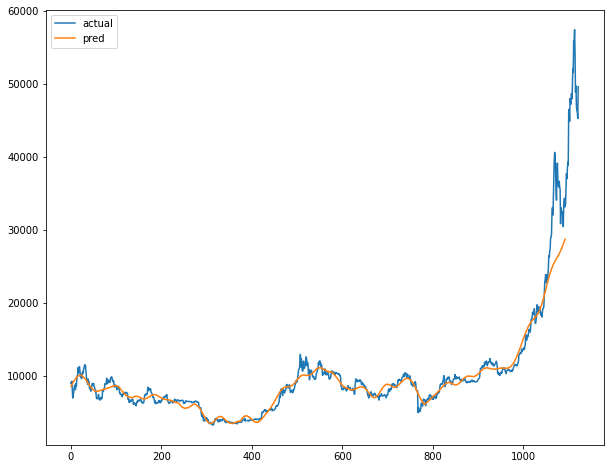

In [10]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

In [11]:
fg_model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
fg_model.add_regressor("score")
fg_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
horizon = 30
fg_model_future = fg_model.make_future_dataframe(horizon)
fg_model_future["score"] = prices_greed_df["score"] 
fg_forecast = fg_model.predict(fg_model_future)

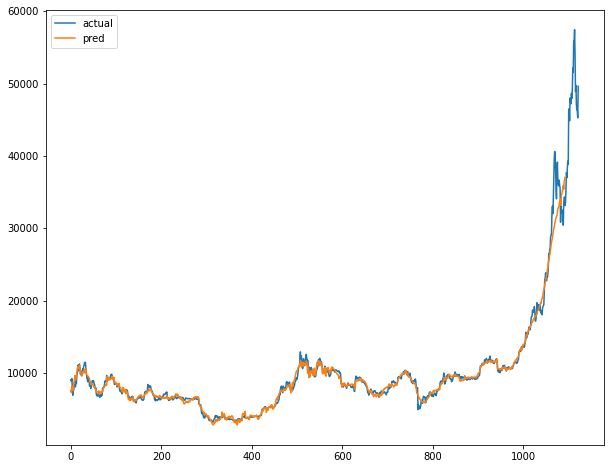

In [14]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(fg_forecast["yhat"], label="pred")
plt.legend()

## Wallet

In [255]:
def wallet(budget, df):
    cash = budget
    btc_value = 0
    for index, row in df.iterrows():
        
        if row['future_change']==1:   
            if cash==0:
                pass
            
            else:
                btc_value = (cash/row['y'])
                print('buy')
                print(row['ds'])
                print(cash)
                cash = 0
                print(btc_value)
                
        if row['future_change']==0 and btc_value>0: 
            cash = btc_value*row['y']
            btc_value = 0
            print('sell')
            print(row['ds'])
            print(cash)

    if cash == 0: 
        portfolio = btc_value*df[-1:]['y'][321]
        return (portfolio, btc_value)
    else:       
        return (cash,btc_value)

In [260]:
comparision

,ds,y,pred,mae,actual_change,pred_change,correct_pred,previous_price,previous_pred_change,future_change
0,2020-04-14,6885.1000,7632.629354,747.529354,0,0,1,NaN,NaN,1.0
1,2020-04-15,6727.1500,7695.392750,968.242750,0,1,0,6885.1000,0.0,1.0
2,2020-04-16,7055.8225,7631.930051,576.107551,1,1,1,6727.1500,1.0,1.0
3,2020-04-17,7086.8500,7772.505867,685.655867,1,1,1,7055.8225,1.0,1.0
4,2020-04-18,7226.6100,7675.834244,449.224244,1,1,1,7086.8500,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
317,2021-02-25,47104.7833,53149.391303,6044.608003,0,1,0,49734.5200,1.0,1.0
318,2021-02-26,46329.7400,52901.877454,6572.137454,0,1,0,47104.7833,1.0,1.0
319,2021-02-27,46189.3783,52577.317016,6387.938716,0,1,0,46329.7400,1.0,1.0
320,2021-02-28,45256.4133,51978.640155,6722.226855,0,1,0,46189.3783,1.0,1.0


In [258]:
wallet(100,comparision)

buy
2020-04-14 00:00:00
100
0.014524117296771288
sell
2020-04-29 00:00:00
120.16455824897243
buy
2020-05-04 00:00:00
120.16455824897243
0.013652953435488654
sell
2020-05-06 00:00:00
126.2754495447792
buy
2020-05-10 00:00:00
126.2754495447792
0.0149165666969599
sell
2020-05-14 00:00:00
142.93923099037076
buy
2020-05-21 00:00:00
142.93923099037076
0.015311937246897025
sell
2020-05-23 00:00:00
140.66819048820432
buy
2020-05-25 00:00:00
140.66819048820432
0.01602811542034656
sell
2020-05-26 00:00:00
142.18621329966533
buy
2020-06-12 00:00:00
142.18621329966533
0.01500495605186449
sell
2020-07-07 00:00:00
139.02654467904395
buy
2020-07-10 00:00:00
139.02654467904395
0.015202939039548412
sell
2020-07-11 00:00:00
141.05362855588214
buy
2020-07-16 00:00:00
141.05362855588214
0.015472641503663167
sell
2020-07-18 00:00:00
141.42392754866853
buy
2020-07-19 00:00:00
141.42392754866853
0.015445852829276682
sell
2020-07-22 00:00:00
144.52985686484362
buy
2020-07-24 00:00:00
144.52985686484362
0.0151

(278.41821478144186, 0.005611048291865529)

## Model Iteration

In [21]:
model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
model.fit(prices_greed_df[:1094])
horizon = 1
model_future = model.make_future_dataframe(horizon) 
forecast = model.predict(model_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
forecast['ds'][1094]

Timestamp('2021-02-02 00:00:00')

## Evaluation Predictions no score

In [64]:
start_index_1=800

In [66]:
predictions = {}
for index in range(start_index_1, 1122):
    model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
    model.fit(prices_greed_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon) 
    forecast = model.predict(model_future)
    predictions[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [122]:
real_preds = {}
for key, value in predictions.items():
    real_preds[key.strftime('%Y-%m-%d')] = [value]

In [123]:
actuals = prices_greed_df[start_index_1:][['ds','y']]

In [124]:
real_preds = pd.DataFrame(real_preds)
real_preds = real_preds.T
real_preds = real_preds.reset_index()
real_preds.columns = ['ds','pred']
real_preds.ds = pd.to_datetime(real_preds.ds)

In [125]:
comparision = pd.merge(actuals,real_preds, on='ds', how='left')
comparision['mae'] = abs(comparision['y'] - comparision['pred'])
comparision['actual_change'] = comparision['y']-comparision.shift(1)['y']
comparision['pred_change'] = comparision['pred']-comparision.shift(1)['y']
comparision['actual_change'] = np.where(comparision['actual_change']>0,1,0)
comparision['pred_change'] = np.where(comparision['pred_change']>0,1,0)
comparision['correct_pred'] = np.where(comparision['pred_change']==comparision['actual_change'], 1, 0)

In [126]:
comparision['correct_pred'].sum()/len(comparision['correct_pred'])

0.5372670807453416

In [127]:
comparision['mae'].mean()

1191.132592807075

In [128]:
comparision['previous_price'] = comparision.shift(1)['y']
comparision['previous_pred_change'] = comparision.shift(1)['pred_change']

In [154]:
comparision['future_change'] = comparision.shift(-1)['pred_change']

In [161]:
wallet(100, comparision_2)

up
100
0.014524117296771288
up
100
0.014865136053157727
up
100
0.014172692127671862
up
100
0.01411064154031763
down
100
up
100
0.01450050824281391
up
100
0.014584062536460156
up
100
0.014009820884439991
down
100
up
100
0.013153325686866666
down
100
up
100
0.01208685614828155
down
100
up
100
0.011339141241477217
down
100
up
100
0.01123557632888779
up
100
0.010812041045751421
up
100
0.010665585887296753
down
100
up
100
0.011812721119373452
up
100
0.011290425013936619
up
100
0.011454819328862135
up
100
0.010989977140847547
up
100
0.010435600215286433
down
100
up
100
0.010565184547361082
up
100
0.010230048209102185
up
100
0.01037715780025009
up
100
0.010214765443448504
up
100
0.010233105015705258
up
100
0.010712200660942781
up
100
0.010895857395018416
up
100
0.01088514552846331
up
100
0.010865868459969598
up
100
0.01139427141610284
up
100
0.011272622744770913
up
100
0.011206930365738173
up
100
0.010860180604803458
down
100
up
100
0.010944211879941995
down
100
up
100
0.010585090899468099
up

(100, 0)

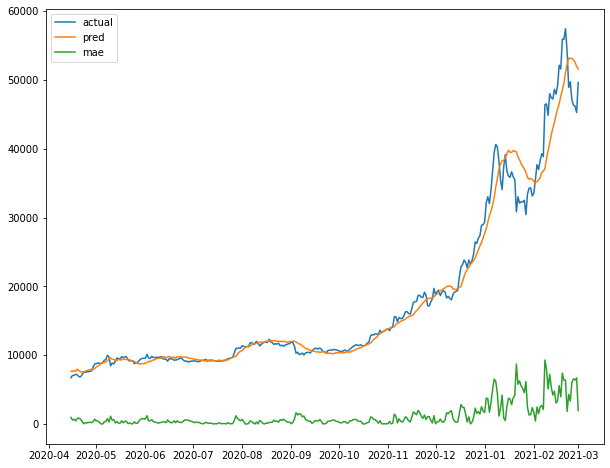

In [131]:
plt.figure(figsize=(10,8))
plt.plot(comparision[1:]['ds'],comparision[1:]['y'], label='actual')
plt.plot(comparision[1:]['ds'],comparision[1:]['pred'], label='pred')
plt.plot(comparision[1:]['ds'],comparision[1:]['mae'], label='mae')
plt.legend()
plt.show()

## Evaluation Predictions 2 (Only Fear and Greed) 1 year period

In [77]:
start_index = 800

In [78]:
predictions_2 = {}
for index in range(start_index, 1122):
    model = Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=0.5)
    model.add_regressor("score")
    model.fit(prices_greed_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon)
    model_future["score"] = prices_greed_df["score"] 
    forecast = model.predict(model_future)
    predictions_2[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [135]:
real_preds_2 = {}
for key, value in predictions_2.items():
    real_preds_2[key.strftime('%Y-%m-%d')] = [value]

In [136]:
actuals_2 = prices_greed_df[start_index:][['ds','y']]

In [137]:
real_preds_2 = pd.DataFrame(real_preds_2)
real_preds_2 = real_preds_2.T
real_preds_2 = real_preds_2.reset_index()
real_preds_2.columns = ['ds','pred']
real_preds_2.ds = pd.to_datetime(real_preds_2.ds)

In [138]:
comparision_2 = pd.merge(actuals_2,real_preds_2, on='ds', how='left')

In [139]:
comparision_2

,ds,y,pred
0,2020-04-14,6885.1000,7114.833504
1,2020-04-15,6727.1500,7238.348367
2,2020-04-16,7055.8225,6969.645973
3,2020-04-17,7086.8500,7130.782098
4,2020-04-18,7226.6100,7177.789150
...,...,...,...
317,2021-02-25,47104.7833,51967.817249
318,2021-02-26,46329.7400,50791.268343
319,2021-02-27,46189.3783,50481.113727
320,2021-02-28,45256.4133,50428.286922


In [140]:
comparision_2['mae'] = abs(comparision_2['y'] - comparision_2['pred'])

In [141]:
comparision_2['actual_change'] = comparision_2['y']-comparision_2.shift(1)['y']
comparision_2['pred_change'] = comparision_2['pred']-comparision_2.shift(1)['y']

In [142]:
comparision_2

,ds,y,pred,mae,actual_change,pred_change
0,2020-04-14,6885.1000,7114.833504,229.733504,NaN,NaN
1,2020-04-15,6727.1500,7238.348367,511.198367,-157.9500,353.248367
2,2020-04-16,7055.8225,6969.645973,86.176527,328.6725,242.495973
3,2020-04-17,7086.8500,7130.782098,43.932098,31.0275,74.959598
4,2020-04-18,7226.6100,7177.789150,48.820850,139.7600,90.939150
...,...,...,...,...,...,...
317,2021-02-25,47104.7833,51967.817249,4863.033949,-2629.7367,2233.297249
318,2021-02-26,46329.7400,50791.268343,4461.528343,-775.0433,3686.485043
319,2021-02-27,46189.3783,50481.113727,4291.735427,-140.3617,4151.373727
320,2021-02-28,45256.4133,50428.286922,5171.873622,-932.9650,4238.908622


In [143]:
comparision_2['actual_change'] = np.where(comparision_2['actual_change']>0,1,0)
comparision_2['pred_change'] = np.where(comparision_2['pred_change']>0,1,0)

In [144]:
comparision_2['correct_pred'] = np.where(comparision_2['pred_change']==comparision_2['actual_change'], 1, 0)

In [212]:
comparision_2['correct_pred'].sum()/len(comparision_2['correct_pred'])

0.5559006211180124

In [146]:
comparision_2['mae'].mean()

1084.0513863149606

In [147]:
comparision_2['previous_price'] = comparision_2.shift(1)['y']

In [148]:
comparision_2['previous_pred_change'] = comparision_2.shift(1)['pred_change']

In [149]:
comparision_2['future_change'] = comparision_2.shift(-1)['pred_change']

In [150]:
comparision_2

,ds,y,pred,mae,actual_change,pred_change,correct_pred,previous_price,previous_pred_change,future_change
0,2020-04-14,6885.1000,7114.833504,229.733504,0,0,1,NaN,NaN,1.0
1,2020-04-15,6727.1500,7238.348367,511.198367,0,1,0,6885.1000,0.0,1.0
2,2020-04-16,7055.8225,6969.645973,86.176527,1,1,1,6727.1500,1.0,1.0
3,2020-04-17,7086.8500,7130.782098,43.932098,1,1,1,7055.8225,1.0,1.0
4,2020-04-18,7226.6100,7177.789150,48.820850,1,1,1,7086.8500,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
317,2021-02-25,47104.7833,51967.817249,4863.033949,0,1,0,49734.5200,1.0,1.0
318,2021-02-26,46329.7400,50791.268343,4461.528343,0,1,0,47104.7833,1.0,1.0
319,2021-02-27,46189.3783,50481.113727,4291.735427,0,1,0,46329.7400,1.0,1.0
320,2021-02-28,45256.4133,50428.286922,5171.873622,0,1,0,46189.3783,1.0,1.0


In [152]:
wallet(100, comparision_2)

up
100
nan
up
100
0.014524117296771288
up
100
0.014865136053157727
up
100
0.014172692127671862
down
102.42051865675475
up
102.42051865675475
0.014283296306018945
up
102.42051865675475
0.01485149575015548
up
102.42051865675475
0.014937072491067955
down
112.87870996137598
up
112.87870996137598
0.01485518854597337
down
114.00428759750439
up
114.00428759750439
0.01475946060051972
down
129.00875524399274
up
129.00875524399274
0.014509312630735807
down
127.70168381565291
up
127.70168381565291
0.014509312630735807
up
127.70168381565291
0.01434802015838263
up
127.70168381565291
0.013807158470264093
down
137.88750076233612
up
137.88750076233612
0.014155643112238155
up
137.88750076233612
0.016288265923528708
up
137.88750076233612
0.015568084877162842
up
137.88750076233612
0.015794764089409
up
137.88750076233612
0.015153804813866726
down
144.31869975631707
up
144.31869975631707
0.015153804813866726
up
144.31869975631707
0.015247536965606847
up
144.31869975631707
0.014763872559820675
up
144.318699

(352.1016294524486, 0)

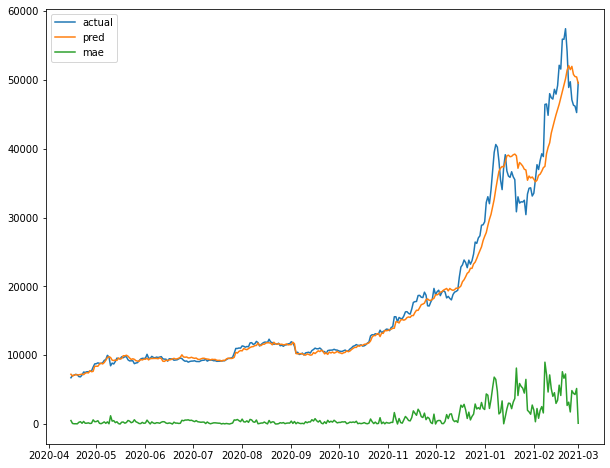

In [121]:
plt.figure(figsize=(10,8))
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['y'], label='actual')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['pred'], label='pred')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['mae'], label='mae')
plt.legend()
plt.show()